### Description
Context
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

 

### Objective
To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

 

### Data Description
The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

### Data Dictionary

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

In [1]:
# this will help in making the Python code more structured automatically (good coding practice)
# %reload_ext nb_black

# Library to suppress warnings or deprecation notes
import warnings

warnings.filterwarnings("ignore")


import pandas as pd

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

import numpy as np
import missingno as msg
from scipy import stats as st
import pandas_profiling
import altair as alt
import math


# libaries to help with data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
import seaborn as sns

sns.set(color_codes=True)
sns.set_style("whitegrid")
# sns.set(style="ticks")


# Libraries to build decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, RidgeClassifier

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    KFold,
    cross_val_score,
    LeaveOneOut,
    StratifiedKFold,
)


# To get diferent metric scores
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
    precision_recall_curve,
    roc_curve,
    make_scorer,
    classification_report,
)


from pandas_profiling import ProfileReport


from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    StackingClassifier,
)

from sklearn.ensemble._forest import ForestClassifier, ForestRegressor

# import treeinterpreter

from sklearn.neighbors import (
    KNeighborsClassifier,
    KNeighborsRegressor,
    KNeighborsTransformer,
    kneighbors_graph,
)

from sklearn.cluster import KMeans
from xgboost import XGBClassifier

from sklearn.svm import SVC

from sklearn.impute import SimpleImputer, MissingIndicator

from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,  # for features
    StandardScaler,
    PolynomialFeatures,
    LabelEncoder,  # convert yes=1 no=0 data alphabetical for targets
    RobustScaler,
)

from sklearn.compose import ColumnTransformer

# We can use Dummy for Baseline
from sklearn.dummy import DummyClassifier, DummyRegressor
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import SCORERS
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA


# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to compute distances
from scipy.spatial.distance import cdist, pdist

print("Setup Done!!!")

Setup Done!!!


In [2]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [3]:
df = pd.read_excel("Credit Card Customer Data.xlsx", engine="openpyxl")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [5]:
print("There are {0} observations and {1} features".format(df.shape[0], df.shape[1]))

There are 660 observations and 7 features


In [6]:
print(f"There are duplicated rows: {df.duplicated().any()}")

There are duplicated rows: False


In [7]:
# ProfileReport(df)

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


In [9]:
#
# for x, y in dict(df.isnull().mean()).items():
#   print(x, y)

_ = [
    print(f"There are {y}% missing rows in {x} ")
    for x, y in dict(df.isnull().mean()).items()
]

There are 0.0% missing rows in Sl_No 
There are 0.0% missing rows in Customer Key 
There are 0.0% missing rows in Avg_Credit_Limit 
There are 0.0% missing rows in Total_Credit_Cards 
There are 0.0% missing rows in Total_visits_bank 
There are 0.0% missing rows in Total_visits_online 
There are 0.0% missing rows in Total_calls_made 


In [10]:
## The columns Sl_no is of no use we can drop it
df.drop("Sl_No", axis=1, inplace=True)

###  Let us check if customer Key has duplicate records,

In [11]:
df["Customer Key"].duplicated().any()


True

In [12]:
# Check Which Keys are duplicate Keys ...
print(
    f' Duplicate customer keys are {list(df.loc[df["Customer Key"].duplicated() == True, "Customer Key"])}'
)
df.loc[
    df["Customer Key"].isin(
        list(df.loc[df["Customer Key"].duplicated() == True, "Customer Key"])
    )
]

 Duplicate customer keys are [47437, 96929, 37252, 50706, 97935]


,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
4,47437,100000,6,0,12,3
48,37252,6000,4,0,2,8
104,97935,17000,2,1,2,10
332,47437,17000,7,3,1,0
391,96929,13000,4,5,0,0
398,96929,67000,6,2,2,2
411,50706,44000,4,5,0,2
432,37252,59000,6,2,1,2
541,50706,60000,7,5,2,2
632,97935,187000,7,1,7,0


#### Customer Key has few duplicate ids , we will drop one duplication row , use keep=First, and create new dataframe , we will use this DataFrame for analysis 


In [13]:
dfx = df.loc[~df["Customer Key"].duplicated() == True]

In [14]:
dfx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 655 entries, 0 to 659
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Customer Key         655 non-null    int64
 1   Avg_Credit_Limit     655 non-null    int64
 2   Total_Credit_Cards   655 non-null    int64
 3   Total_visits_bank    655 non-null    int64
 4   Total_visits_online  655 non-null    int64
 5   Total_calls_made     655 non-null    int64
dtypes: int64(6)
memory usage: 35.8 KB


In [15]:
dfx.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer Key,655.0,55058.158779,25606.965469,11265.0,33623.5,53898.0,77084.5,99843.0
Avg_Credit_Limit,655.0,34242.748092,37240.896986,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,655.0,4.691603,2.169325,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,655.0,2.401527,1.633648,0.0,1.0,2.0,4.0,5.0
Total_visits_online,655.0,2.606107,2.940380,0.0,1.0,2.0,4.0,15.0
Total_calls_made,655.0,3.601527,2.867352,0.0,1.0,3.0,5.0,10.0


In [16]:
for col in df.columns:
    print("-" * 80)
    print(df[col].value_counts())

--------------------------------------------------------------------------------
47437    2
37252    2
97935    2
96929    2
50706    2
        ..
66706    1
72339    1
69965    1
85645    1
71681    1
Name: Customer Key, Length: 655, dtype: int64
--------------------------------------------------------------------------------
8000      35
6000      31
9000      28
13000     28
10000     26
19000     26
7000      24
11000     24
18000     23
14000     23
17000     23
16000     22
5000      21
20000     20
12000     18
15000     17
36000     11
70000     10
38000      8
50000      8
56000      7
39000      7
68000      7
52000      6
37000      6
34000      6
30000      6
74000      6
47000      6
48000      6
41000      6
60000      5
29000      5
26000      5
65000      5
31000      5
54000      4
51000      4
59000      4
73000      4
71000      4
49000      4
69000      4
64000      4
66000      4
33000      4
28000      3
67000      3
62000      3
100000     3
72000      3
61000   

In [17]:
for col in df.columns:
    print("-" * 80)
    print(col)
    print(df[col].unique())

--------------------------------------------------------------------------------
Customer Key
[87073 38414 17341 40496 47437 58634 48370 37376 82490 44770 52741 52326
 92503 25084 68517 55196 62617 96463 39137 14309 29794 87241 30507 61061
 24001 68067 65034 14854 81130 29112 13999 32550 82164 61517 28254 30888
 46388 74126 52142 37659 83132 20119 52363 50769 68502 99026 83326 62040
 37252 74625 51182 60301 96386 43886 78503 68419 32828 17937 71632 81566
 29759 36929 70248 91673 61355 60403 85868 76205 66524 69214 21976 35149
 27120 18821 33187 93482 90168 71881 59656 12026 99589 38970 57990 39447
 79694 79403 47296 37559 38165 49198 18007 59619 37016 91099 74704 25742
 11937 52736 88338 18916 92501 96213 26599 73007 97935 26089 14946 74795
 73435 41634 84069 83244 87291 18086 33369 15310 98499 35256 89007 93997
 16577 25440 81116 63663 69811 36111 39454 70199 11602 49697 28701 61627
 34103 14248 31256 45583 52750 95507 23743 53410 53898 66200 58389 61347
 59151 37802 60475 95489 77758

### Observations:
 - Total_visits_bank , Total_visits_online , Total_calls_made have minimum values as zero , which looks valid observationb so we will not delete or impute it
 - There were no duplicate record in Dataframe 
 - Customer key was duplicated but could be valid , we will drop duplicate customer key for analysis 
 - We will bring duplicate Customer key back again as it could be valid record 
 - There are no missing value
 - There are no out of bound values , all outliers so far look valid 

## EDA

### Univariate Analysis

<Figure size 432x288 with 0 Axes>

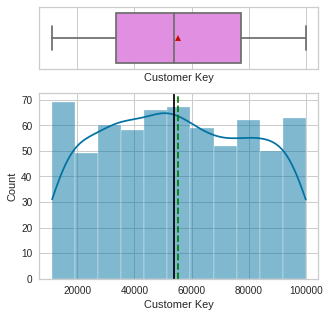

<Figure size 432x288 with 0 Axes>

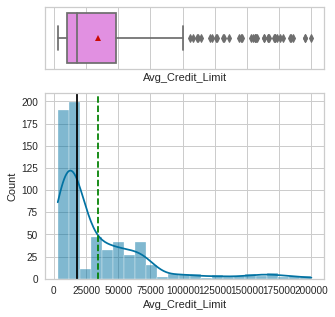

<Figure size 432x288 with 0 Axes>

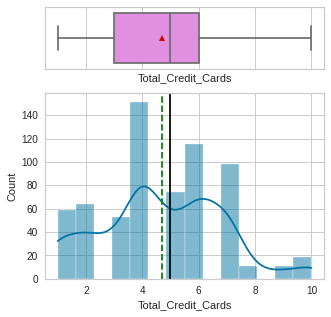

<Figure size 432x288 with 0 Axes>

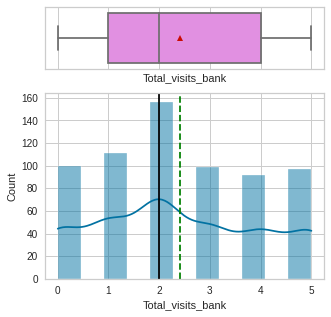

<Figure size 432x288 with 0 Axes>

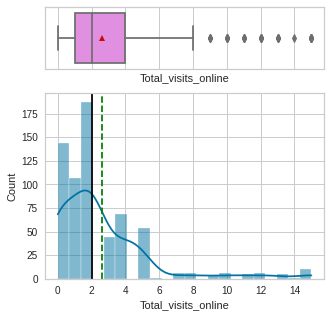

<Figure size 432x288 with 0 Axes>

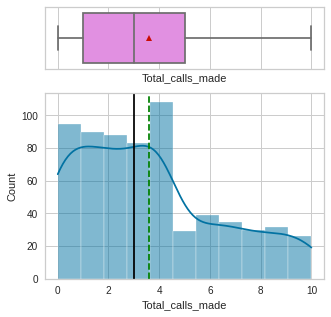

In [18]:
# selecting numerical columns
num_col = dfx.select_dtypes(include=np.number).columns.tolist()

for item in num_col:
    fig = plt.figure()
    histogram_boxplot(dfx, item, figsize=(5, 5), kde=True)
    plt.show()

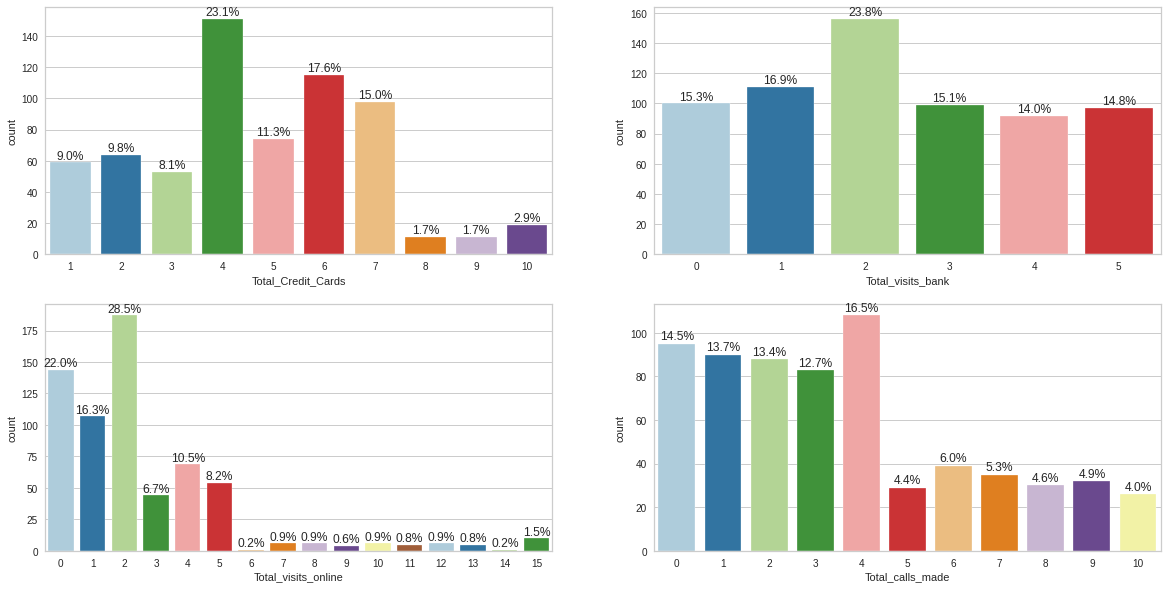

In [19]:
fig = plt.figure(figsize=(20, 10))
numcol = [
    "Total_Credit_Cards",
    "Total_visits_bank",
    "Total_visits_online",
    "Total_calls_made",
]
for i, col in enumerate(numcol):
    ax = fig.add_subplot(2, 2, i + 1)
    sns.countplot(
        data=dfx, x=col, palette="Paired", ax=ax,
    )
    for p in ax.patches:
        label = "{:.1f}%".format(100 * p.get_height() / len(dfx))
        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height() + 1  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the p

### Observations:
 - There are outliers in Avg Credit Limit and Total Visits online but looks all valid we will keep it
 - in average 4 or less calls were made to customer 
 - It looks like the higher number of credit card holders have higher Avg Credit Limit and make use of Online banking more , possibly to check expenditure ,increase the credit limit 
 - 66% Customer hold 4 or more Credit Cards 
 - 23% Customer visited bank personally twice in a year 15% made 5 visits 
 - 22% customer did not do any online activity, while 68% customers made between 1-5 online activity
 - Bank made 4 or less calls per customer in an year 
 - There are outliers in Avg_Credit_Limit and Total_visits_online but that do seems to be a valid data, as we find some relation with Total_Credit_Cards  We will keep Outliers 

### Bivariate Analysis

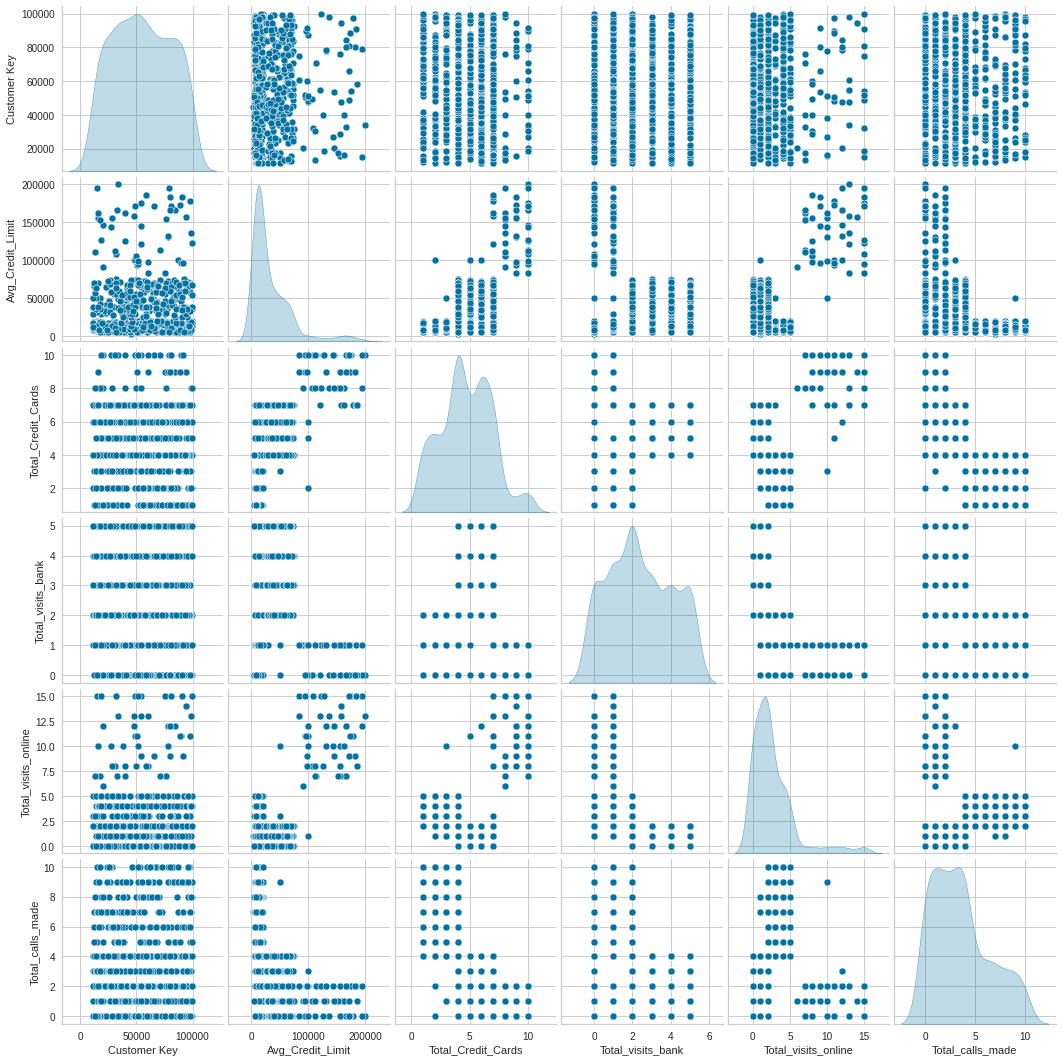

In [20]:
sns.pairplot(dfx, diag_kind="kde")

### Observations:
- Total_visits_online and Avg_Credit_Limit Right skewed. More and More user should be encoraged to visit online for more business 
- Total_calls_made bx Total_visit_online show two major cluster , less visitors got more calls. 
- Similar two cluster groups are seen with many features ( Intertesing to see how they will be clustred)

In [21]:
dfx.corr()

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Customer Key,1.000000,0.057904,-0.013169,0.002569,0.018467,0.009295
Avg_Credit_Limit,0.057904,1.000000,0.611015,-0.097462,0.551740,-0.412691
Total_Credit_Cards,-0.013169,0.611015,1.000000,0.316306,0.168144,-0.649331
Total_visits_bank,0.002569,-0.097462,0.316306,1.000000,-0.552092,-0.508962
Total_visits_online,0.018467,0.551740,0.168144,-0.552092,1.000000,0.128981
Total_calls_made,0.009295,-0.412691,-0.649331,-0.508962,0.128981,1.000000


In [22]:
found = 0
corcols = list(dfx.corr().columns)
for colsx in corcols:
    tempxs = [x for x in corcols if x != colsx]
    for temps in tempxs:
        corval = dfx[[colsx, temps]].corr()[colsx][1]
        if abs(corval) > 0.95:
            print(f"corelation value between {colsx} and {temps} is {corval:0.2f}")
            found += 1
if not found:
    print(f"no high correlation between features found")

no high correlation between features found


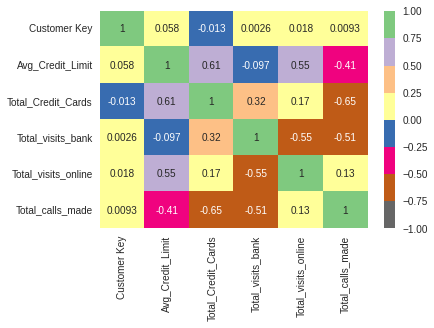

In [23]:
sns.heatmap(dfx.corr(), vmin=-1, vmax=1, annot=True, cmap=cm.Accent_r)

### Observations:
- No specific High correlation found between two features 

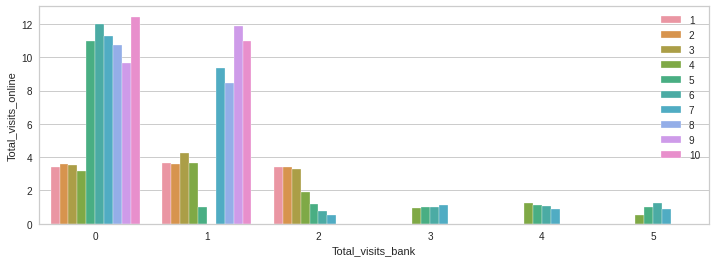

In [24]:
# fig, ax = plt.subplots(111,figsize=(10, 10))
fig = plt.figure(figsize=(12, 4))
sns.barplot(
    data=dfx,
    x="Total_visits_bank",
    y="Total_visits_online",
    hue="Total_Credit_Cards",
    ci=None,
)
plt.legend(loc="upper right")
plt.show()

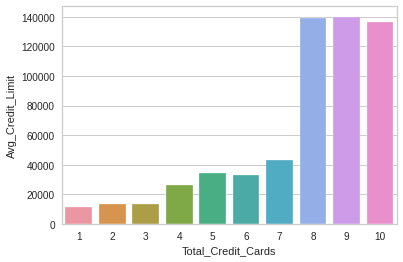

In [25]:
# fig, ax = plt.subplots(111,figsize=(10, 10))
fig = plt.figure(figsize=(6, 4))
sns.barplot(data=dfx, x="Total_Credit_Cards", y="Avg_Credit_Limit", ci=None)

plt.show()

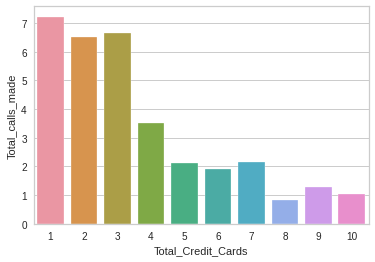

In [26]:
fig = plt.figure(figsize=(6, 4))
sns.barplot(data=dfx, x="Total_Credit_Cards", y="Total_calls_made", ci=None)

plt.show()

### Observations:
- customer with 8 or more credit cards used online banking more that others
- Customer with 8 or more Credit cards have higher credit limits
- More calls were made to Customer with 4 or less credit cards

### Data Preprocessing 

In [27]:
# No outlier treament needed 
# we will not drop duplicate customer ids as that could be valid entries
# Drop Customer Key colums from clustering 

In [28]:
custdata = df.drop("Customer Key", axis=1)

In [29]:
custdata.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


In [30]:
# Due to mismatch in the feature we will scale it using standard scaling

In [31]:
subset_scaled_df = custdata.apply(st.zscore)

In [34]:
subset_scaled_df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


## KMeans Clustering

#### Deciding number of clusters

We don't know how many clusters need to build for correct grouping of data. There are multiple ways to decide the k value.

Elbow plot using inertia_ which is sum of the squared distance to centroid and see where the curve bends as that value of k is best choice for the clustering. Similar elbow curve can be plotted against distortion

#### validating the k value

There are mutliple ways to cross validate the cluster. 

   ***Silhoutte Coefficient*** : is a value between 


Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.9908683849620169
Number of Clusters: 6 	Average Distortion: 0.9426543606899347
Number of Clusters: 7 	Average Distortion: 0.9093991915419353
Number of Clusters: 8 	Average Distortion: 0.8843243844476886
Number of Clusters: 9 	Average Distortion: 0.8650832420580971
Number of Clusters: 10 	Average Distortion: 0.8411372125672628
Number of Clusters: 11 	Average Distortion: 0.8231750888188956


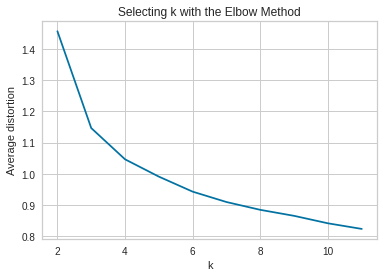

In [35]:
clusters = range(2, 12)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k, random_state=1)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.show()

Number of Clusters: 2 	Average Inertia: 2040.9898164784945
Number of Clusters: 3 	Average Inertia: 933.0437490000536
Number of Clusters: 4 	Average Inertia: 780.7736895551766
Number of Clusters: 5 	Average Inertia: 704.4759188657507
Number of Clusters: 6 	Average Inertia: 642.4285451423204
Number of Clusters: 7 	Average Inertia: 600.2238778375963
Number of Clusters: 8 	Average Inertia: 574.4418958177622
Number of Clusters: 9 	Average Inertia: 538.8269188945015
Number of Clusters: 10 	Average Inertia: 509.16313788912584
Number of Clusters: 11 	Average Inertia: 491.206987252707


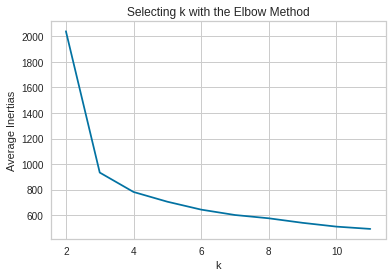

In [36]:
clusters = range(2, 12)
Inertias = []

for k in clusters:
    model = KMeans(n_clusters=k, random_state=1)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    Inertias.append(model.inertia_)
    print("Number of Clusters:", k, "\tAverage Inertia:", model.inertia_)

plt.plot(clusters, Inertias, "bx-")
plt.xlabel("k")
plt.ylabel("Average Inertias")
plt.title("Selecting k with the Elbow Method")
plt.show()

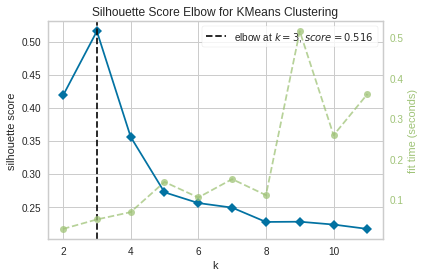

In [37]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
vz = KElbowVisualizer(model, k=range(2, 12), metric="silhouette")
vz.fit(subset_scaled_df)  # Fit the data to the visualizer
vz.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d39f50c10>,
      dtype=object)

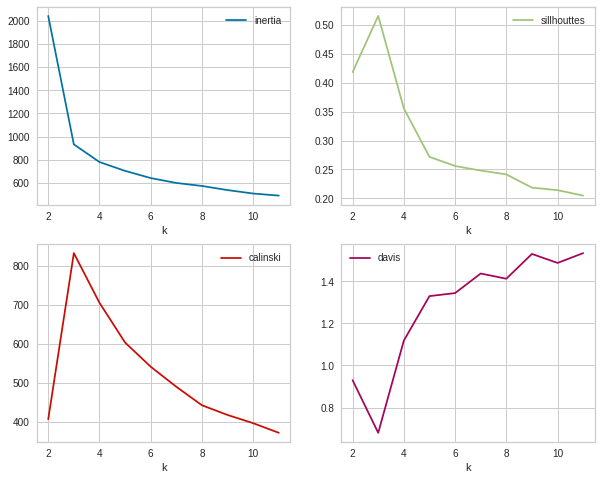

In [38]:
inertias = []
sils = []
chs = []
dbs = []
sizes = range(2, 12)
for k in sizes:
    k2 = KMeans(random_state=1, n_clusters=k)
    k2.fit(subset_scaled_df)
    inertias.append(k2.inertia_)
    sils.append(silhouette_score(subset_scaled_df, k2.labels_))
    chs.append(calinski_harabasz_score(subset_scaled_df, k2.labels_))
    dbs.append(davies_bouldin_score(subset_scaled_df, k2.labels_))

fig, ax = plt.subplots(figsize=(10, 8))
pd.DataFrame(
    {
        "inertia": inertias,
        "sillhouttes": sils,
        "calinski": chs,
        "davis": dbs,
        "k": sizes,
    },
).set_index("k").plot(ax=ax, subplots=True, layout=(2, 2))

### Observations:
 We don't 